In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [2]:
release=None

In [5]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-01,2021-01-31,United Kingdom,K02000001,3839,NaN,102.0,574012.0
1,2021-02-01,2021-01-30,United Kingdom,K02000001,14020,NaN,302.0,439006.0
2,2021-02-01,2021-01-29,United Kingdom,K02000001,20397,NaN,598.0,662675.0
3,2021-02-01,2021-01-28,United Kingdom,K02000001,23516,2981.0,853.0,753031.0
4,2021-02-01,2021-01-27,United Kingdom,K02000001,25523,3041.0,915.0,771710.0
...,...,...,...,...,...,...,...,...
363,2021-02-01,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
364,2021-02-01,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
365,2021-02-01,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
366,2021-02-01,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [6]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-01.csv')

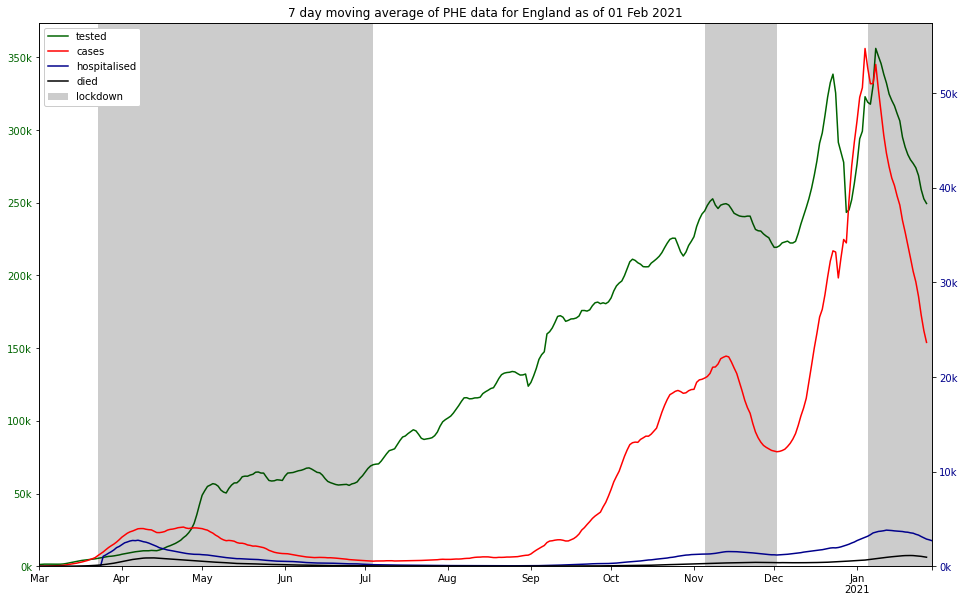

In [7]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [8]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-01.csv')

In [9]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-01.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,24612.0,221809.0,197197.0,1893667,1.299701,10.413499,88.286800
1,Scotland,S92000003,7849.0,575897.0,568048.0,5463300,0.143668,10.397525,89.458807
2,Wales,W92000004,841.0,416306.0,415465.0,3152879,0.026674,13.177321,86.796005
3,England,E92000001,460907.0,8082355.0,7621448.0,56286961,0.818852,13.540344,85.640804


'9,296,367'

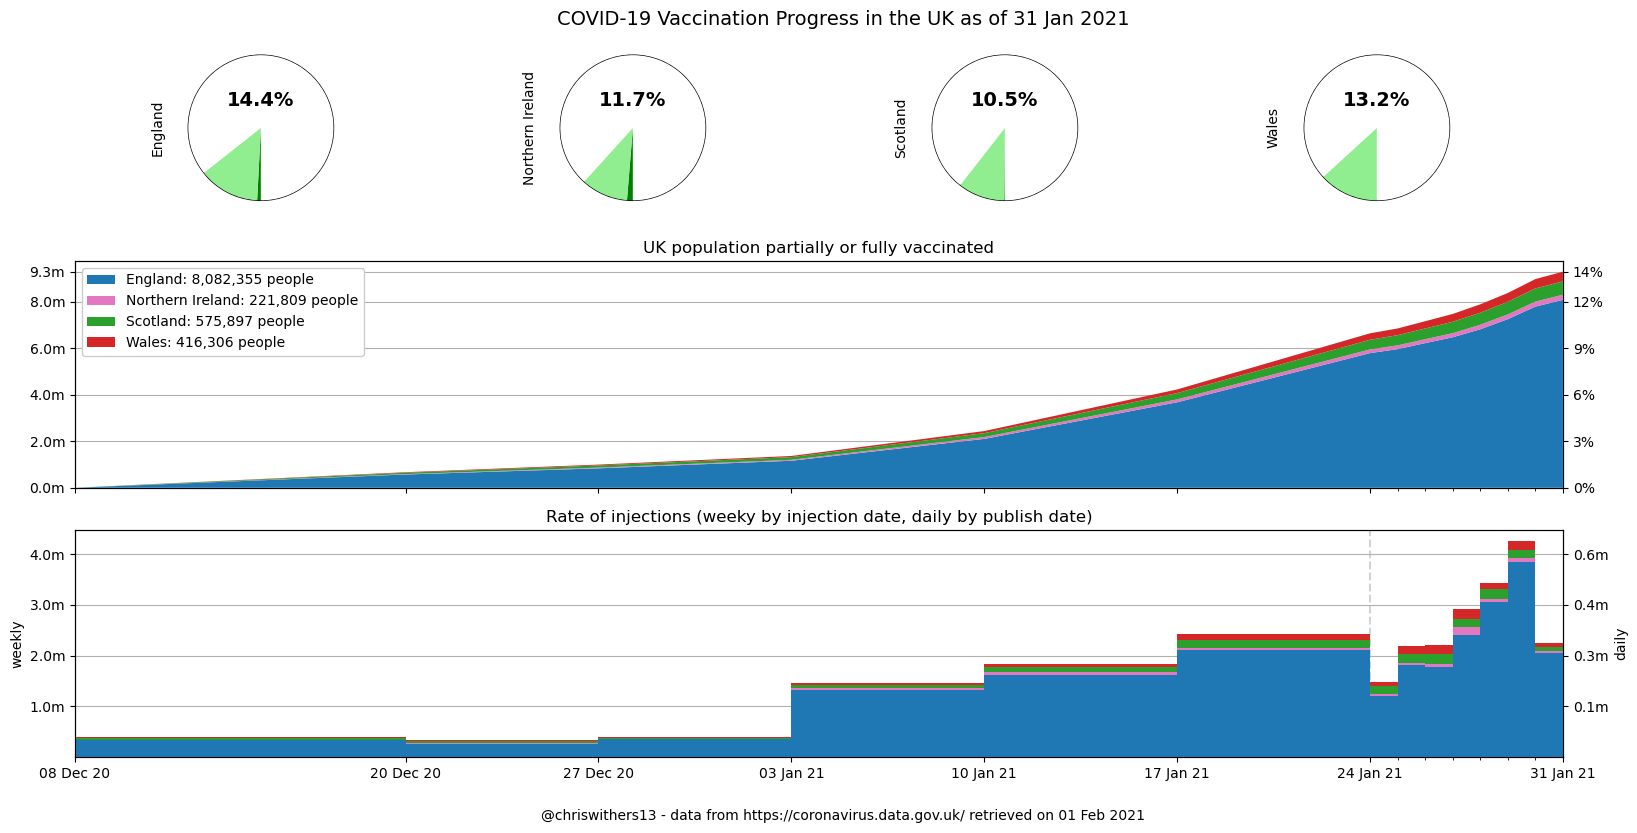

In [8]:
results = vaccination_dashboard()
display(results, f"{results['any'].sum():,.0f}")

In [11]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,31 Jan 21,"+289,359","+2,757","+2,757","+8,082,355","+460,907","+460,907"
Northern Ireland,31 Jan 21,"+7,208",+289,+289,"+221,809","+24,612","+24,612"
Scotland,31 Jan 21,"+9,628",+55,+55,"+575,897","+7,849","+7,849"
Wales,31 Jan 21,"+12,843",+55,+55,"+416,306",+841,+841


In [12]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-01.csv')

In [13]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-01.csv')

In [14]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-01.csv')

In [15]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-02-01, release: 2021-02-01 16:00:31.191253+00:00, msoa: 2021-02-01 16:18:51+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-02-01.csv')